Can't use tensorflow 2.11 (latest) because of this bug:
https://github.com/keras-team/keras-io/issues/1241

In [4]:
# !pip install tensorflow~=2.10.0

In [5]:
import tensorflow as tf
print(tf.__version__)

2.10.1


# Use TFTS package for tuning
https://github.com/LongxingTan/Time-series-prediction

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

2023-05-07 14:24:37.381682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 14:24:37.566041: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-07 14:24:37.566060: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-07 14:24:37.604706: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-07 14:24:38.214381: W tensorflow/stream_executor/platform/de

In [2]:
import tfts
from tfts import AutoModel, AutoConfig, KerasTrainer

In [3]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [6]:
tf.random.set_seed(42)
np.random.seed(42)

In [7]:
train_df = pd.read_csv('../data/ch18_train.csv')
val_df = pd.read_csv('../data/ch18_val.csv')
test_df = pd.read_csv('../data/ch18_test.csv')

print(train_df.shape, val_df.shape, test_df.shape)

(24464, 7) (6990, 7) (3495, 7)


In [8]:
train_df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2,day_sin,day_cos
0,0.553644,0.103358,0.934691,0.549618,0.144652,0.370590,0.982963
1,0.518286,0.110073,0.929321,0.510981,0.030869,0.500000,1.000000
2,0.498217,0.096987,0.932664,0.490311,0.000000,0.629410,0.982963
3,0.465887,0.099010,0.944965,0.459659,0.008973,0.750000,0.933013
4,0.335359,0.072536,0.951346,0.335526,0.002872,0.853553,0.853553
...,...,...,...,...,...,...,...
24459,0.391731,0.178648,0.952719,0.380975,0.169060,0.629410,0.982963
24460,0.428573,0.208782,0.955031,0.414210,0.085427,0.750000,0.933013
24461,0.127220,0.155790,0.973043,0.122725,0.000000,0.853553,0.853553
24462,0.038508,0.056263,0.983021,0.036054,0.000000,0.933013,0.750000


## `DataWindow` class 

In [9]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Global_active_power', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='red', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)

        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [10]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

In [11]:
val_performance = {}
performance = {}

In [12]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['Global_active_power'])

In [13]:
steps_per_epoch = train_df.shape[0]//32

In [14]:
steps_per_epoch

764

In [15]:
validation_steps = val_df.shape[0]//32
validation_steps

218

## TFTS Tuning 

### Seq2Seq

In [16]:
tfts_seq2seq = AutoModel("seq2seq", predict_length=multi_window.label_width)
trainer = KerasTrainer(tfts_seq2seq)
trainer.train(
    train_dataset=multi_window.train, 
    valid_dataset=multi_window.val,
    n_epochs=1,
    verbose=2,
    batch_size=32,
    # steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callback_eval_metrics=[MeanAbsoluteError()]
)

2023-05-07 14:24:40.071874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-07 14:24:40.071940: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-07 14:24:40.071961: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-TG8G71EP): /proc/driver/nvidia/version does not exist
2023-05-07 14:24:40.072272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


764/764 - 184s - loss: 0.0185 - mean_absolute_error: 0.1043 - val_loss: 0.0156 - val_mean_absolute_error: 0.0905 - 184s/epoch - 241ms/step


In [17]:
val_performance['TFTS - seq2seq'] = trainer.get_model().evaluate(multi_window.val)
performance['TFTS - seq2seq'] = trainer.get_model().evaluate(multi_window.test, verbose=0)

217/217 [==============================] - 22s 101ms/step - loss: 0.0156 - mean_absolute_error: 0.0905


In [18]:
# multi_window.plot(tfts_seq2seq)

# plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)

In [19]:
# trainer.save_model(model_dir="seq2seq")

In [20]:
# result = next(iter(multi_window.train))
# print(result)

In [21]:
# list(multi_window.train.as_numpy_iterator())[:10]

### Transformer

In [22]:
tfts_transformer = AutoModel("transformer", predict_length=multi_window.label_width)
trainer_transformer = KerasTrainer(tfts_transformer)
trainer_transformer.train(
    train_dataset=multi_window.train,
    valid_dataset=multi_window.val, 
    n_epochs=1,
    verbose=2,
    batch_size=32,
    # steps_per_epoch=steps_per_epoch,
    callback_eval_metrics=[MeanAbsoluteError()]
)

764/764 - 62s - loss: 0.1033 - mean_absolute_error: 0.1471 - val_loss: 0.0169 - val_mean_absolute_error: 0.1042 - 62s/epoch - 81ms/step


In [23]:
val_performance['TFTS - transformer'] = trainer.get_model().evaluate(multi_window.val)
performance['TFTS - transformer'] = trainer.get_model().evaluate(multi_window.test, verbose=0)

217/217 [==============================] - 21s 95ms/step - loss: 0.0156 - mean_absolute_error: 0.0905


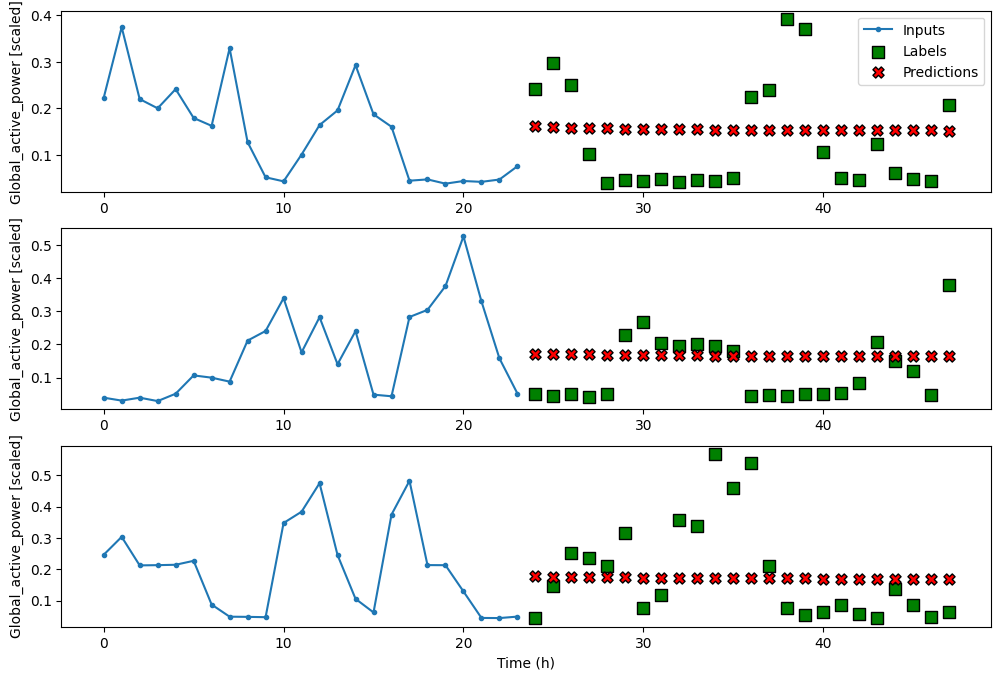

In [24]:
multi_window.plot(tfts_transformer)

# plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)

### Bert

In [25]:
tfts_bert = AutoModel("bert", predict_length=multi_window.label_width)
trainer = KerasTrainer(tfts_bert)
trainer.train(train_dataset=multi_window.train, valid_dataset=multi_window.val, n_epochs=1, callback_eval_metrics=[MeanAbsoluteError()])

764/764 - 48s - loss: 0.0343 - mean_absolute_error: 0.1188 - val_loss: 0.0170 - val_mean_absolute_error: 0.1055 - 48s/epoch - 63ms/step


In [26]:
val_performance['TFTS - bert'] = trainer.get_model().evaluate(multi_window.val)
performance['TFTS - bert'] = trainer.get_model().evaluate(multi_window.test, verbose=0)

217/217 [==============================] - 5s 24ms/step - loss: 0.0170 - mean_absolute_error: 0.1055


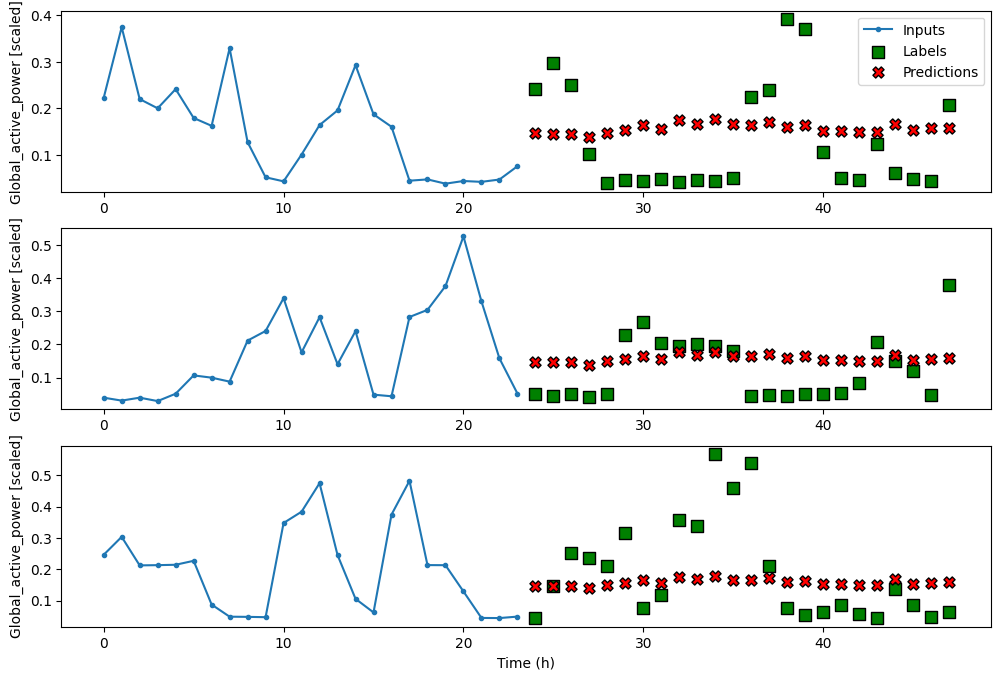

In [27]:
multi_window.plot(tfts_bert)

# plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)

### RNN

In [28]:
tfts_rnn = AutoModel("rnn", predict_length=multi_window.label_width)
trainer = KerasTrainer(tfts_rnn)
trainer.train(train_dataset=multi_window.train, valid_dataset=multi_window.val, n_epochs=1, callback_eval_metrics=[MeanAbsoluteError()])

764/764 - 88s - loss: 0.0146 - mean_absolute_error: 0.0899 - val_loss: 0.0126 - val_mean_absolute_error: 0.0823 - 88s/epoch - 116ms/step


In [29]:
val_performance['TFTS - rnn'] = trainer.get_model().evaluate(multi_window.val)
performance['TFTS - rnn'] = trainer.get_model().evaluate(multi_window.test, verbose=0)

217/217 [==============================] - 10s 46ms/step - loss: 0.0126 - mean_absolute_error: 0.0823


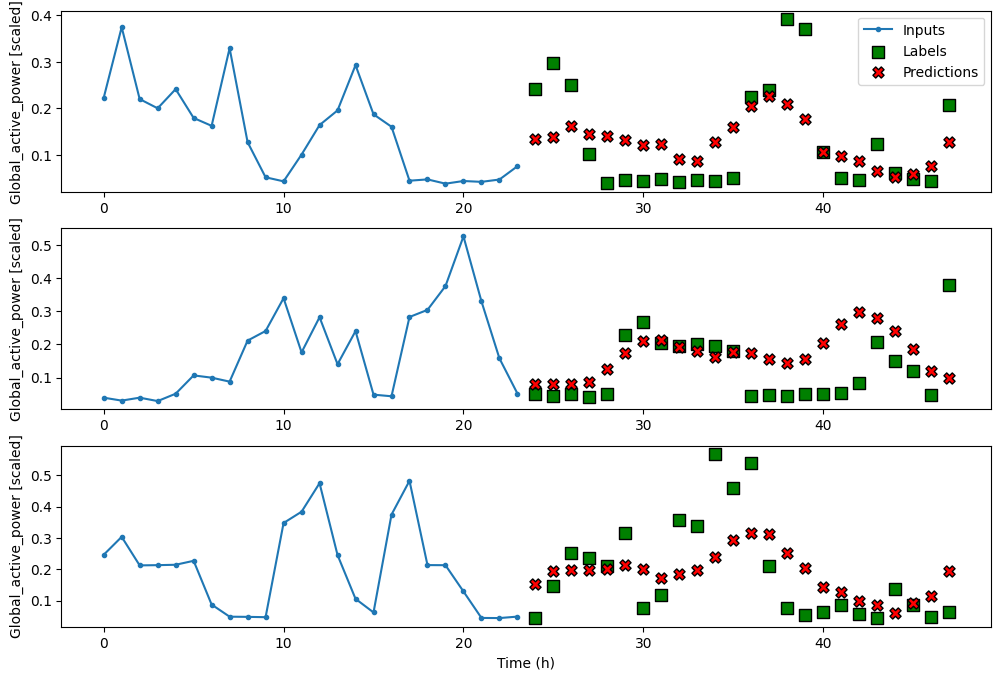

In [30]:
multi_window.plot(tfts_rnn)

# plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)

### Informer

In [31]:
tfts_informer = AutoModel("informer", predict_length=multi_window.label_width)
trainer = KerasTrainer(tfts_informer)
trainer.train(
    train_dataset=multi_window.train, 
    valid_dataset=multi_window.val, 
    n_epochs=1, 
    callback_eval_metrics=[MeanAbsoluteError()]
)

764/764 - 80s - loss: 0.0493 - mean_absolute_error: 0.1307 - val_loss: 0.0170 - val_mean_absolute_error: 0.1047 - 80s/epoch - 105ms/step


In [32]:
val_performance['TFTS - informer'] = trainer.get_model().evaluate(multi_window.val)
performance['TFTS - informer'] = trainer.get_model().evaluate(multi_window.test, verbose=0)

217/217 [==============================] - 10s 45ms/step - loss: 0.0170 - mean_absolute_error: 0.1047


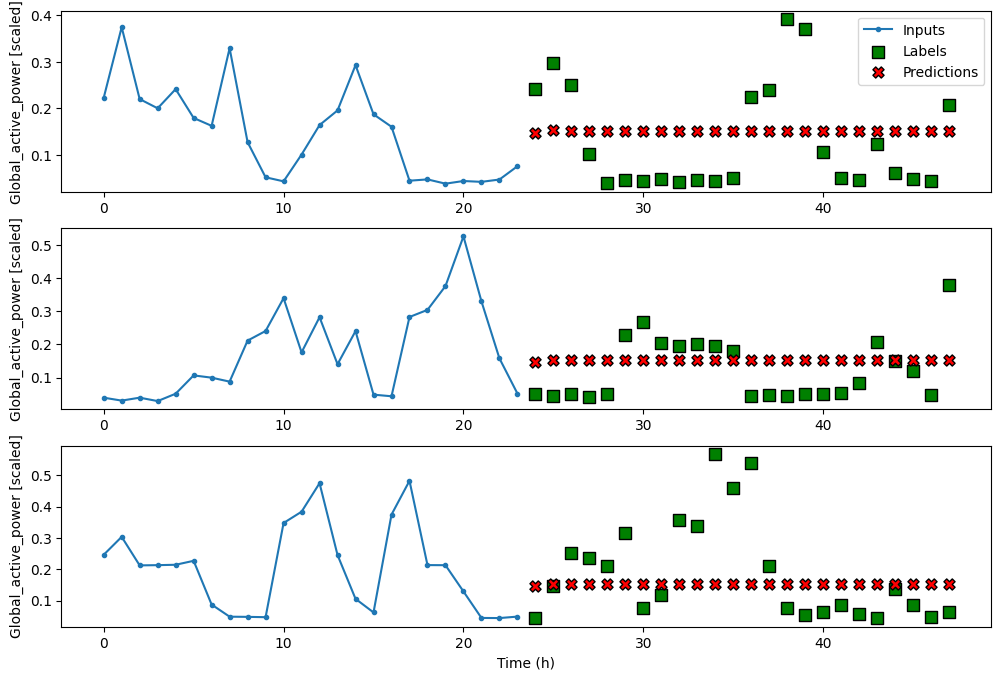

In [33]:
multi_window.plot(tfts_informer)

# plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)

### TCN

In [36]:
tfts_tcn = AutoModel("tcn", predict_length=multi_window.label_width)
trainer = KerasTrainer(tfts_tcn)
trainer.train(
    train_dataset=multi_window.train, 
    valid_dataset=multi_window.val, 
    n_epochs=1, 
    callback_eval_metrics=[MeanAbsoluteError()]
)

764/764 - 103s - loss: 0.0227 - mean_absolute_error: 0.1162 - val_loss: 0.0167 - val_mean_absolute_error: 0.1049 - 103s/epoch - 135ms/step


In [37]:
val_performance['TFTS - tcn'] = trainer.get_model().evaluate(multi_window.val)
performance['TFTS - tcn'] = trainer.get_model().evaluate(multi_window.test, verbose=0)

217/217 [==============================] - 11s 50ms/step - loss: 0.0167 - mean_absolute_error: 0.1049


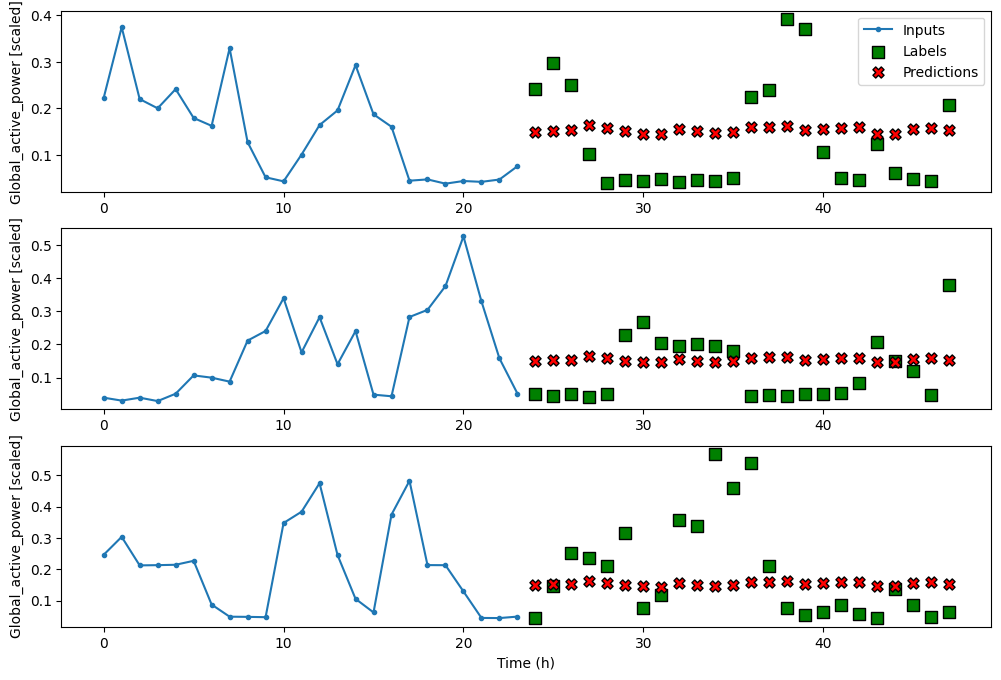

In [38]:
multi_window.plot(tfts_tcn)

# plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)

### WaveNet

In [39]:
tfts_wavenet = AutoModel("wavenet", predict_length=multi_window.label_width)
trainer = KerasTrainer(tfts_wavenet)
trainer.train(
    train_dataset=multi_window.train, 
    valid_dataset=multi_window.val, 
    n_epochs=1, 
    callback_eval_metrics=[MeanAbsoluteError()]
)

764/764 - 489s - loss: 0.0178 - mean_absolute_error: 0.1023 - val_loss: 0.0129 - val_mean_absolute_error: 0.0840 - 489s/epoch - 641ms/step


In [40]:
val_performance['TFTS - wavenet'] = trainer.get_model().evaluate(multi_window.val)
performance['TFTS - wavenet'] = trainer.get_model().evaluate(multi_window.test, verbose=0)

217/217 [==============================] - 68s 311ms/step - loss: 0.0129 - mean_absolute_error: 0.0840


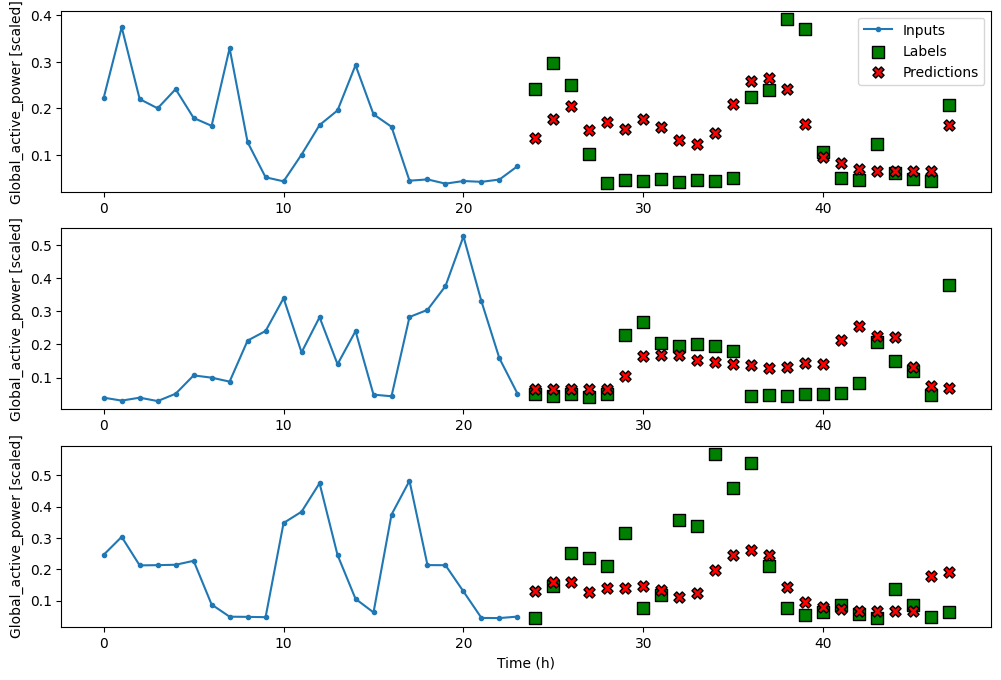

In [41]:
multi_window.plot(tfts_wavenet)

# plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)

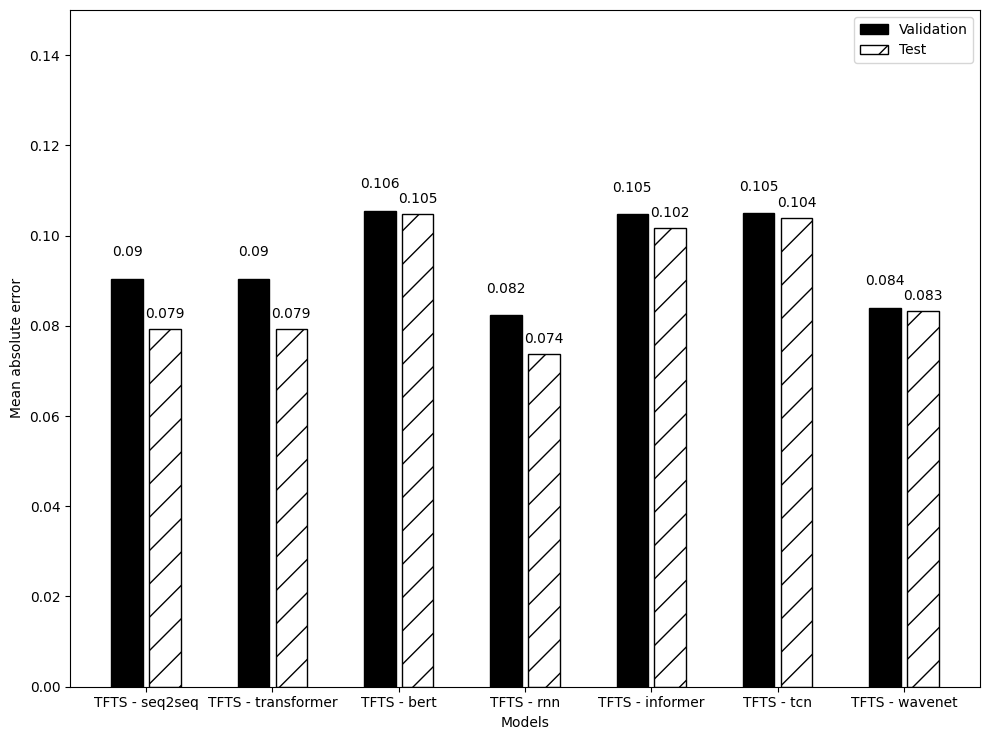

In [53]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.005, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.15)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

# plt.savefig('figures/CH18_F14_peixeiro.png', dpi=300)

# Debug

### Autoformer

In [43]:
# tfts_autoformer = AutoModel("autoformer", predict_length=multi_window.label_width)
# trainer = KerasTrainer(tfts_autoformer)
# trainer.train(train_dataset=multi_window.train, valid_dataset=multi_window.val, n_epochs=1, callback_eval_metrics=[MeanAbsoluteError()])

In [44]:
# val_performance['TFTS - autoformer'] = trainer.get_model().evaluate(multi_window.val)
# performance['TFTS - autoformer'] = trainer.get_model().evaluate(multi_window.test, verbose=0)

In [45]:
# multi_window.plot(tfts_autoformer)

# plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)

### Unet

In [46]:
# tfts_unet = AutoModel("unet", predict_length=multi_window.label_width)
# trainer = KerasTrainer(tfts_unet)
# trainer.train(
#     train_dataset=multi_window.train, 
#     valid_dataset=multi_window.val, 
#     n_epochs=1, 
#     callback_eval_metrics=[MeanAbsoluteError()]
# )

In [47]:
# val_performance['TFTS - unet'] = trainer.get_model().evaluate(multi_window.val)
# performance['TFTS - unet'] = trainer.get_model().evaluate(multi_window.test, verbose=0)

In [48]:
# multi_window.plot(tfts_unet)

# plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)

### NBeats

In [49]:
# tfts_nbeats = AutoModel("nbeats", predict_length=multi_window.label_width)
# trainer = KerasTrainer(tfts_nbeats)
# trainer.train(
#     train_dataset=multi_window.train, 
#     valid_dataset=multi_window.val, 
#     n_epochs=1, 
#     callback_eval_metrics=[MeanAbsoluteError()]
# )

In [50]:
# val_performance['TFTS - nbeats'] = trainer.get_model().evaluate(multi_window.val)
# performance['TFTS - nbeats'] = trainer.get_model().evaluate(multi_window.test, verbose=0)

In [51]:
# multi_window.plot(tfts_nbeats)

# plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)